## RNN Iteration 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

### Load the dataset

In [4]:
file_path = 'processed_dataset_v2.csv'
df = pd.read_csv(file_path)

### Drop the unnecessary columns

In [7]:
df.drop(columns=['dataset_source', 'Sentiment_Score', 'POS_Tags',
       'TF_IDF', 'GloVe_Embeddings', 'PERSON', 'ORG', 'GPE', 'LOC', 'NORP',
       'Num_PERSON', 'Num_ORG', 'Num_GPE', 'Num_LOC', 'Num_NORP', 'Has_PERSON',
       'Has_ORG', 'Has_GPE', 'Has_LOC', 'Has_NORP'])

,sentence,emotion,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new
0,That game hurt.,sadness,"['that', 'game', 'hurt', '.']","['DET', 'NOUN', 'VERB', 'PUNCT']",-0.5267,"[-0.18378876149654388, 0.21825924515724182, -0..."
1,"You do right, if you don't care then fuck 'em!",neutral,"['you', 'do', 'right', ',', 'if', 'you', 'do',...","['PRON', 'VERB', 'NOUN', 'PUNCT', 'SCONJ', 'PR...",0.1316,"[-0.13493569195270538, 0.12419985234737396, -0..."
2,Man I love reddit.,happiness,"['man', 'i', 'love', 'reddit', '.']","['NOUN', 'PRON', 'VERB', 'PROPN', 'PUNCT']",0.6369,"[-0.0781317949295044, 0.17847399413585663, -0...."
3,"Etenia was nowhere near them, he was by the Fa...",neutral,"['etenia', 'was', 'nowhere', 'near', 'them', '...","['PROPN', 'AUX', 'ADV', 'ADP', 'PRON', 'PUNCT'...",0.0000,"[0.02850472740828991, 0.07425817847251892, -0...."
4,Right? Considering it's such an important docu...,happiness,"['right', '?', 'considering', 'it', ""'s"", 'suc...","['INTJ', 'PUNCT', 'VERB', 'PRON', 'AUX', 'DET'...",0.6239,"[-0.029261890798807144, 0.11021193861961365, -..."
...,...,...,...,...,...,...
463225,that was what i felt when i was finally accept...,happiness,"['that', 'was', 'what', 'i', 'felt', 'when', '...","['PRON', 'AUX', 'PRON', 'PRON', 'VERB', 'SCONJ...",0.2732,"[0.1046690046787262, 0.22912077605724335, -0.1..."
463226,i take every day as it comes i m just focussin...,fear,"['i', 'take', 'every', 'day', 'as', 'it', 'com...","['PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'PRON...",0.5859,"[-0.040616925805807114, 0.25056716799736023, -..."
463227,i just suddenly feel that everything was fake,sadness,"['i', 'just', 'suddenly', 'feel', 'that', 'eve...","['PRON', 'ADV', 'ADV', 'VERB', 'SCONJ', 'PRON'...",-0.4767,"[-0.004944764077663422, 0.24434252083301544, -..."
463228,im feeling more eager than ever to claw back w...,happiness,"['i', 'm', 'feeling', 'more', 'eager', 'than',...","['PRON', 'AUX', 'VERB', 'ADV', 'ADJ', 'ADP', '...",0.5095,"[0.06295980513095856, 0.2330499142408371, -0.1..."


### Define Tokenizer and Pre Process the Tokens

In [ ]:
# define tokenizer
tokenizer = Tokenizer()
# create a vocabulary of words from the text data
df['Tokens_str'] = df['Tokens'].apply(lambda x: ' '.join(x))
# fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Tokens_str'])
# convert the text data to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Tokens_str'])
max_len = 50
# pad the sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

### Pre-Process the Pos Tags

In [ ]:
# encode the labels
df['POS_Tags_new'] = df['POS_Tags_new'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# flatten the list of lists to get all unique tags
all_tags = [tag for seq in df['POS_Tags_new'] for tag in seq]
# initialize the label encoder and fit it on the unique tags
le_pos = LabelEncoder()
le_pos.fit(all_tags)
# create a new column with the encoded labels
df['POS_Encoded'] = df['POS_Tags_new'].apply(lambda tags: le_pos.transform(tags))
pos_padded = pad_sequences(df['POS_Encoded'], maxlen=max_len, padding='post')

### Pre-Process the Sentiment Score

In [ ]:
# initialize the one-hot encoder and fit it on the unique tags
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(df[['Sentiment_Score_new']])

### Get the Word2Vec Embeddings to train the model on them

In [ ]:
from gensim.models import Word2Vec

# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec_emotion.model")  # Use your saved model file

# function to get sentence embeddings
def get_sentence_embedding(sentence, embedding_dim=300):
    """Computes sentence embeddings by averaging Word2Vec word vectors."""
    words = sentence.split()
    # Filter out words not in the Word2Vec model vocabulary
    word_vectors = [
        word2vec_model.wv[word] for word in words if word in word2vec_model.wv
    ]
    # If no words are found in the model, return a zero vector
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)  # Return zero vector if no words found
    
    return np.mean(word_vectors, axis=0)  # Average word embeddings for the sentence
# Convert sentences to string format
df["sentence"] = df["sentence"].astype(str)
# Apply function to dataset
df["Word2Vec_Embedding"] = df["sentence"].apply(lambda x: get_sentence_embedding(x).tolist())
# Convert the list of embeddings to a numpy array
X_word2vec = np.vstack(df["Word2Vec_Embedding"].values)

print(f"✅ Word2Vec Embeddings Shape: {X_word2vec.shape}")

✅ Word2Vec Embeddings Shape: (463230, 300)


### Pre-process the labels using label encoder

In [ ]:
# initialize label encoder
label_encoder = LabelEncoder()
# fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(df['emotion'])
# convert the labels to a one-hot encoded format
onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(int_labels.reshape(-1, 1))

### Train/Val split the dataset and the feature to prepare for training

In [ ]:
# Define the input features and labels
X_text = padded_sequences
X_pos = pos_padded
X_sentiment = sentiment_scaled
X_glove = X_word2vec # set the word2vec embeddings to be named as X_glove
y = labels


# Set validation split percentage
val_size = 0.2  # 20% of the data for validation

# Perform train-validation split
X_train_text, X_val_text, \
X_train_pos, X_val_pos, \
X_train_sent, X_val_sent, \
X_train_glove, X_val_glove, \
y_train, y_val = train_test_split(
    X_text, X_pos, X_sentiment, X_glove, y,
    test_size=val_size, random_state=42, stratify=y
)

# Print dataset sizes
print(f"Train Samples: {len(X_train_text)}")
print(f"Validation Samples: {len(X_val_text)}")


📊 Train Samples: 370584
📊 Validation Samples: 92646


### Define class-weights, so there is more attention to the less represented classes

In [3]:
#  Get label counts again
class_counts = {
    "happiness": 168071,
    "sadness": 129437,
    "anger": 67216,
    "fear": 49008,
    "neutral": 28223,
    "surprise": 19525,
    "disgust": 1750,  
}

# Compute initial class weights
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / (len(class_counts) * count) for label, count in class_counts.items()}

# Fine-Tune Class-Weights Manually
class_weights["disgust"] *= 0.8   
class_weights["happiness"] *= 1.2  
class_weights["sadness"] *= 1.15   
class_weights["anger"] *= 1.1      
class_weights["neutral"] *= 1.0    
class_weights["surprise"] *= 1.0  
class_weights["fear"] *= 1.0       

# Convert to Keras format
label_encoder = LabelEncoder()
# Fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(list(class_counts.keys()))
class_weight_dict = {int_labels[i]: class_weights[label] for i, label in enumerate(class_counts.keys())}

print("Adjusted Class Weights:", class_weight_dict)

Adjusted Class Weights: {3: 0.4724839927343631, 5: 0.5879468114107359, 0: 1.0829755670418608, 2: 1.3503043234923744, 4: 2.3447441549698573, 6: 3.3892811413938175, 1: 30.251755102040818}


### Define the model architecture

In [ ]:
# INPUTS 
max_len = X_train_text.shape[1]
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(le_pos.classes_) + 1
n_classes = y_train.shape[1]

# Text input (Tokens)
text_input = Input(shape=(max_len,), name='text_input')
text_emb = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input) # Embedding layer to convert words to vectors
text_rnn = Bidirectional(SimpleRNN(64, return_sequences=False))(text_emb) # Bidirectional RNN layer to process the sequence of word vectors

# POS input
pos_input = Input(shape=(max_len,), name='pos_input')
pos_emb = Embedding(input_dim=pos_vocab_size, output_dim=16, input_length=max_len)(pos_input) # Embedding layer to convert POS tags to vectors
pos_rnn = Bidirectional(SimpleRNN(32, return_sequences=False))(pos_emb) # Bidirectional RNN layer to process the sequence of POS tag vectors

# Sentiment input
sentiment_input = Input(shape=(1,), name='sentiment_input') # Input layer for sentiment score
sent_dense = Dense(16, activation='relu')(sentiment_input) # Dense layer to process the sentiment score

# Word2Vec input
glove_input = Input(shape=(300,), name='glove_input') # Input layer for Word2Vec embeddings named 'glove_input'
glove_dense = Dense(64, activation='relu')(glove_input)

# Concatenate all inputs
merged = Concatenate()([text_rnn, pos_rnn, sent_dense, glove_dense])
x = Dense(128, activation='relu')(merged) # Dense layer to process the concatenated features
x = Dropout(0.4)(x) # Dropout layer to prevent overfitting
x = Dense(64, activation='relu')(x) # Dense layer to further process the features
output = Dense(n_classes, activation='softmax')(x) # Output layer with softmax activation for multi-class classification

# initialize the model
model = Model(inputs=[text_input, pos_input, sentiment_input, glove_input], outputs=output)
# print the model summary
model.summary()

C:\Users\vl4di\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_input           │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │      4,992 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 16)    │        304 │ pos_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ glove_input         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     24,704 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │      3,136 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         32 │ sentiment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     19,264 │ glove_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 272)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     34,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        455 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,087 (375.34 KB)

 Trainable params: 96,087 (375.34 KB)

 Non-trainable params: 0 (0.00 B)

### Define the f1-score the model is going to be evaluated

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
# define custom metrics
def f1_micro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


### Compile the model and train it on the features

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_micro])
# fit the model and store the training history
history = model.fit(
    x={
        'text_input': X_train_text, # input for text data
        'pos_input': X_train_pos, # input for POS tags
        'sentiment_input': X_train_sent, # input for sentiment score
        'glove_input': X_train_glove # input for Word2Vec embeddings
    },
    y=y_train, # target labels
    # validation data for evaluation during training
    validation_data=(
        {
            'text_input': X_val_text,
            'pos_input': X_val_pos,
            'sentiment_input': X_val_sent,
            'glove_input': X_val_glove
        },
        y_val
    ),
    # define batch size and number of epochs
    batch_size=64,
    epochs=10,
    # use class weights to handle class imbalance
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - accuracy: 0.5416 - f1_micro: 0.2871 - loss: 1.3210 - val_accuracy: 0.6782 - val_f1_micro: 0.5052 - val_loss: 0.8530
Epoch 2/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 157s 27ms/step - accuracy: 0.6681 - f1_micro: 0.5019 - loss: 0.9663 - val_accuracy: 0.7044 - val_f1_micro: 0.5374 - val_loss: 0.8099
Epoch 3/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 136s 24ms/step - accuracy: 0.6845 - f1_micro: 0.5226 - loss: 0.9136 - val_accuracy: 0.7064 - val_f1_micro: 0.5327 - val_loss: 0.7693
Epoch 4/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 129s 22ms/step - accuracy: 0.6936 - f1_micro: 0.5366 - loss: 0.8784 - val_accuracy: 0.6917 - val_f1_micro: 0.5356 - val_loss: 0.8046
Epoch 5/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 133s 23ms/step - accuracy: 0.7028 - f1_micro: 0.5475 - loss: 0.8451 - val_accuracy: 0.7213 - val_f1_micro: 0.5617 - val_loss: 0.7303
Epoch 6/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 130s 22ms/step - accuracy: 0.7094 - f1_micro: 0.5565 - loss: 0.8218 - val_accuracy:

### Save the model as h5 file

In [20]:
model.save("emotion_rnn_model_v4.h5")

### Plot the model learning curves

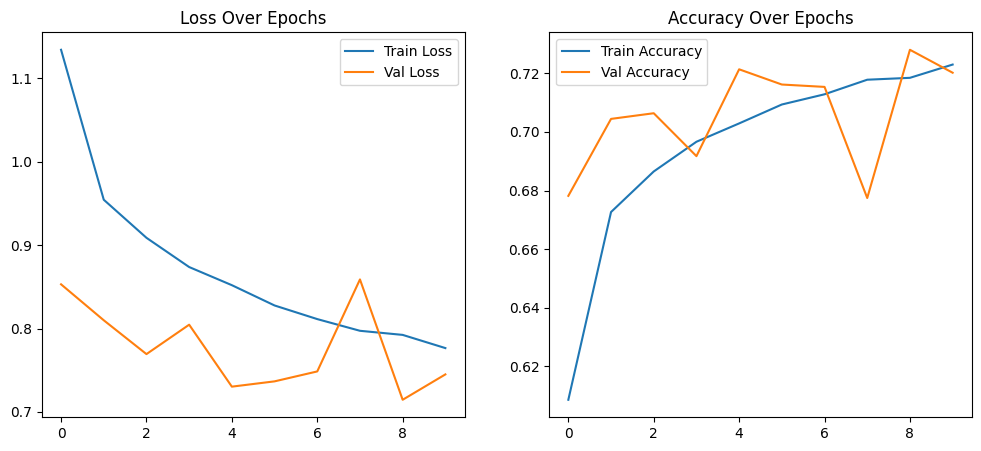

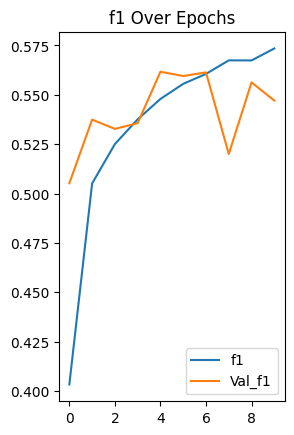

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()
# plot f1 score
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_micro'], label='f1')
plt.plot(history.history['val_f1_micro'], label='Val_f1')
plt.legend()
plt.title("f1 Over Epochs")
plt.show()

### Plot bar plot to see per-class Recall (Prediction Rate)

2896/2896 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step


C:\Users\vl4di\AppData\Local\Temp\ipykernel_4356\2752300191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(recalls.keys()), y=list(recalls.values()), palette="Set2")


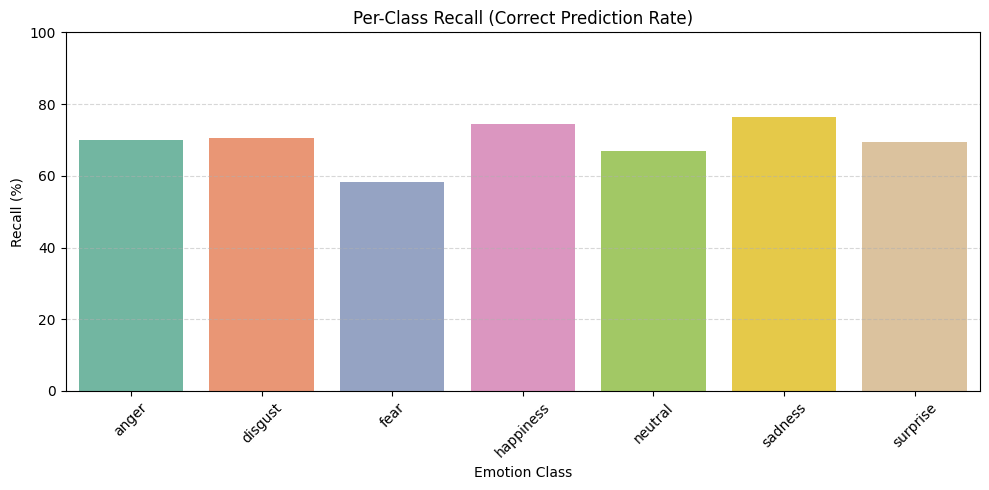

In [ ]:
import seaborn as sns
# Get true and predicted labels 
y_pred_probs = model.predict({
    'text_input': X_val_text,
    'pos_input': X_val_pos,
    'sentiment_input': X_val_sent,
    'glove_input': X_val_glove
})

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

#  Get per-class recall from classification report 
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
recalls = {label: round(metrics["recall"] * 100, 2) for label, metrics in report.items() if label in target_names}

# Plot 
plt.figure(figsize=(10, 5))
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()), palette="Set2")
plt.ylabel("Recall (%)")
plt.xlabel("Emotion Class")
plt.title("Per-Class Recall (Correct Prediction Rate)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Print Per-Class Recall

In [ ]:
print("Per-Class Recall (Correct Prediction Rate):\n")
for emotion, recall in recalls.items():
    print(f"{emotion:<10}: {recall:.2f}%")


📊 Per-Class Recall (Correct Prediction Rate):

anger     : 70.07%
disgust   : 70.57%
fear      : 58.36%
happiness : 74.52%
neutral   : 66.86%
sadness   : 76.48%
surprise  : 69.50%


### Plot Confusion Matrix of Recall % per Class

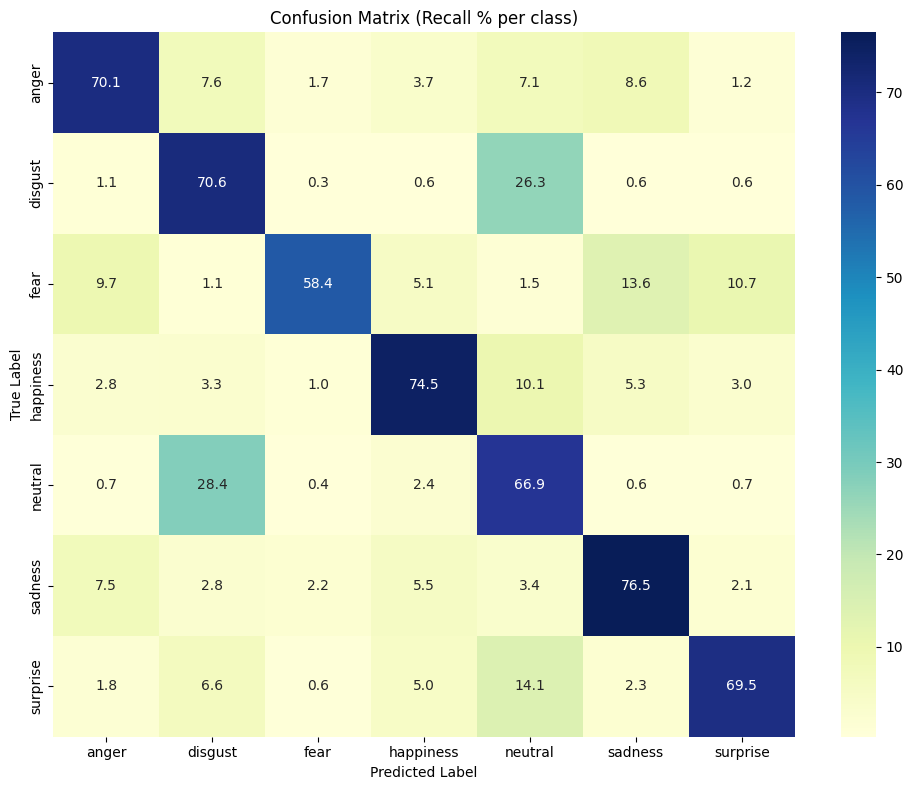

In [ ]:
from sklearn.metrics import confusion_matrix

# Prepare true and predicted labels 
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
labels = label_encoder.classes_

# Compute confusion matrix 
cm = confusion_matrix(y_true, y_pred)

# Normalize to percentages (optional but helpful) 
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot 
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Recall % per class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()